In [56]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings

from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

import os

import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

In [57]:
#import / citire date din xls 
df = pd.read_excel('consum_gaze_2023.xls')
print(df)
print(len(df))

      perioada  consum
0   2014-01-01    1392
1   2014-02-01    1301
2   2014-03-01    1064
3   2014-04-01     954
4   2014-05-01     777
..         ...     ...
114 2023-07-01     423
115 2023-08-01     407
116 2023-09-01     434
117 2023-10-01     629
118 2023-11-01    1089

[119 rows x 2 columns]
119


In [58]:
#indexare coloane
df=df.set_index('perioada')
df.columns
df

,consum
perioada,
2014-01-01,1392
2014-02-01,1301
2014-03-01,1064
2014-04-01,954
2014-05-01,777
...,...
2023-07-01,423
2023-08-01,407
2023-09-01,434


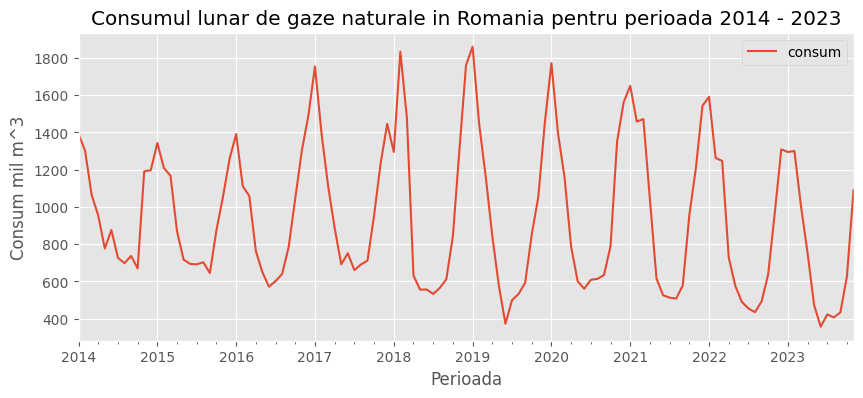

In [59]:
#grafic reprezentare consum lunar 
#plot consum lunar
df.plot(figsize=(10, 4),label = 'Consum')
plt.xlabel("Perioada")
plt.ylabel('Consum mil m^3')
plt.title("Consumul lunar de gaze naturale in Romania pentru perioada 2014 - 2023")
plt.legend()
plt.show()

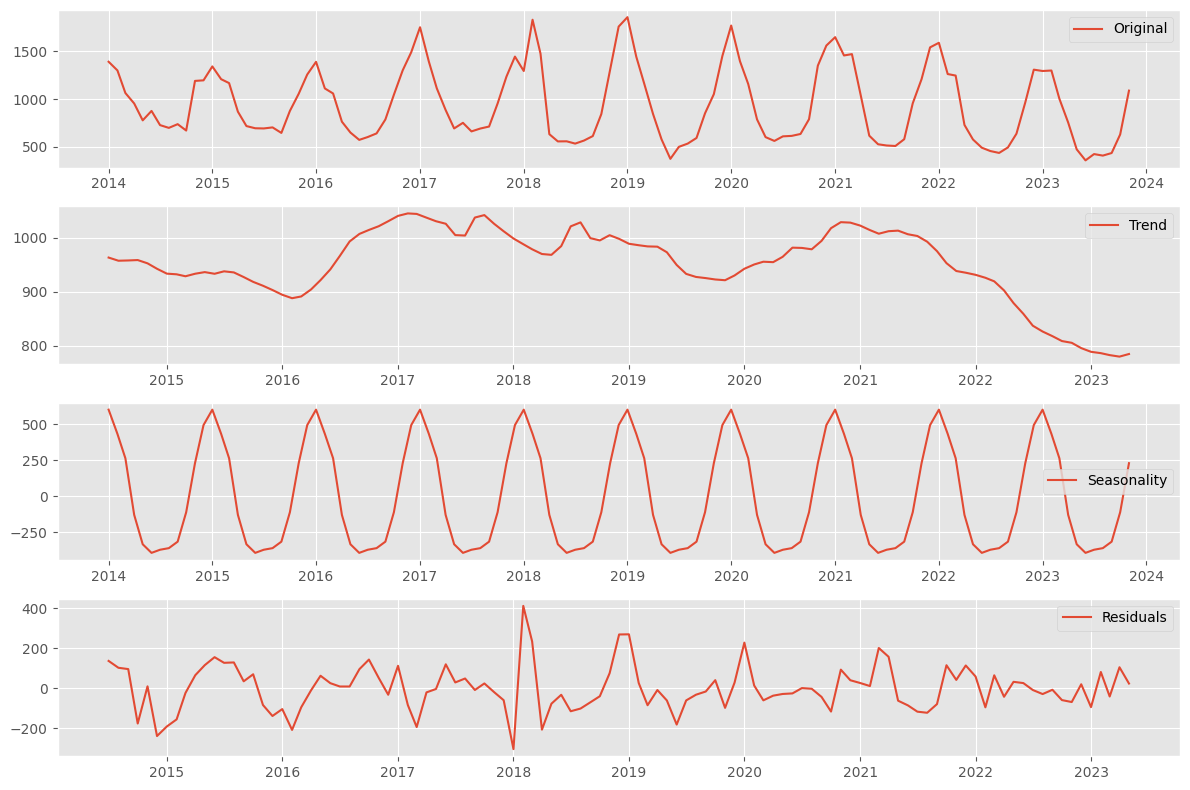

In [60]:
#se observa ca seria prezinta sezonalitate
#descompunere sezoniera

decomposition = seasonal_decompose(df,period=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [61]:
#def functie de testare a stationaritatii 

def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])
    

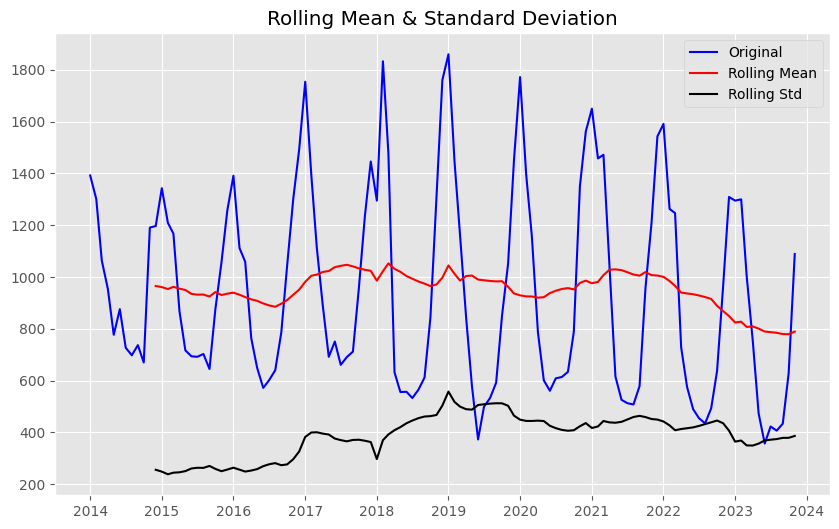

Results of Dickey-Fuller Test:
p-value= 0.9335630138833356


In [62]:
test_stationarity(df)
#cum p-value 0.93>0.1 se accepta ipoteza nula cum ca seria nu este stationara

In [63]:
#diferentiem seria si testam din nou stationaritatea

df_dif = df.diff()
print(df_dif)

            consum
perioada          
2014-01-01     NaN
2014-02-01   -91.0
2014-03-01  -237.0
2014-04-01  -110.0
2014-05-01  -177.0
...            ...
2023-07-01    66.0
2023-08-01   -16.0
2023-09-01    27.0
2023-10-01   195.0
2023-11-01   460.0

[119 rows x 1 columns]


In [64]:
#se observa o valoare NaN pentru prima perioada,respectiv ian 2014 
#vom elimina valorile NaN din serie pentru a testa stationaritatea seriei diferentiate 
df_dif = df_dif.dropna()
df_dif

,consum
perioada,
2014-02-01,-91.0
2014-03-01,-237.0
2014-04-01,-110.0
2014-05-01,-177.0
2014-06-01,99.0
...,...
2023-07-01,66.0
2023-08-01,-16.0
2023-09-01,27.0


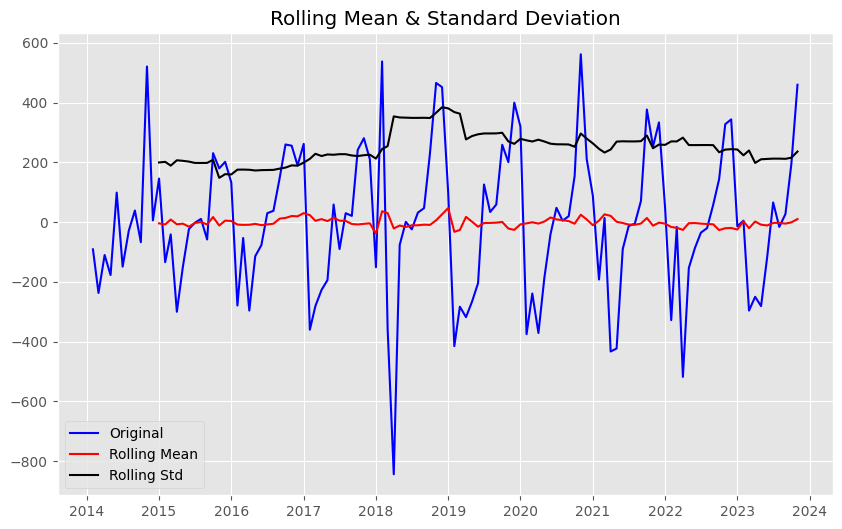

Results of Dickey-Fuller Test:
p-value= 0.007273675226354793


In [65]:
test_stationarity(df_dif)
#cum p-value 0.007 <0.1 se refuza ipoteza nula =>noua serie diferentiata este stationara 
#in continuae vom lucra pe seria stationara

In [66]:
#split in seturi de testare si antrenare
#target:previziune 16 valori (anul 2022 + 3 luni din 2023) - aprox. 13%
#set de antrenare - 87% din serie 103
#set de testare - 13% din serie 16
X=df
train_size = int(len(X) * 0.87)
trainset, testset= X[0:train_size], X[train_size:]

In [67]:
trainset

,consum
perioada,
2014-01-01,1392
2014-02-01,1301
2014-03-01,1064
2014-04-01,954
2014-05-01,777
...,...
2022-03-01,1247
2022-04-01,729
2022-05-01,576


In [68]:
testset

,consum
perioada,
2022-08-01,435
2022-09-01,493
2022-10-01,637
2022-11-01,965
2022-12-01,1309
2023-01-01,1295
2023-02-01,1300
2023-03-01,1004
2023-04-01,754


In [69]:
#export dataframe-urile din seturile de test si train in fisiere excel 
test='testset.xlsx'
train='trainset.xlsx'
testset.to_excel(test)
trainset.to_excel(train)

In [70]:
#split in train si test pentru seria diferentiata 
Y=df_dif
trainD_size = int(len(Y) * 0.87)
trainDset, testDset= Y[0:trainD_size], Y[trainD_size:]

In [71]:
trainDset

,consum
perioada,
2014-02-01,-91.0
2014-03-01,-237.0
2014-04-01,-110.0
2014-05-01,-177.0
2014-06-01,99.0
...,...
2022-03-01,-16.0
2022-04-01,-518.0
2022-05-01,-153.0


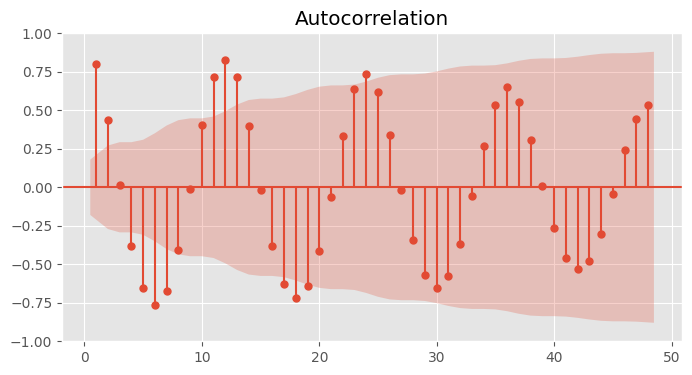

In [72]:
#1. Model SARIMA -Seasonal ARIMA

#ACF 
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=48)
plt.show()

#conform ACF lagul maximal optim ar fi 19 // ultimul lag efectiv in afara intervalului 
#cum datele se repeta la 12 luni - lagul maximal admis ar fi 2
#se observa sezonalitatea seriei cu frecventa o data la 7-8 luni 

In [73]:
#cautare lag optim prin auto_arima 
#m=12 date lunare
#d=1 serie diferentiata
#D=1 diferenta sezoniera
#max_p=2 #lag maximal
import pmdarima as pm
model_12 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

#summary model optim
print(model_12.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1206.119, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1180.966, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1169.916, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1204.185, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1198.664, Time=0.24 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1171.627, Time=0.35 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1171.573, Time=2.15 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1178.754, Time=0.32 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=4.14 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1181.816, Time=0.60 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1171.835, Time=1.27 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1171.878, Time=0.51 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1170.436, Time=0.46 sec
 ARIMA(1,0,2)(0,1,1)[12] inte

C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


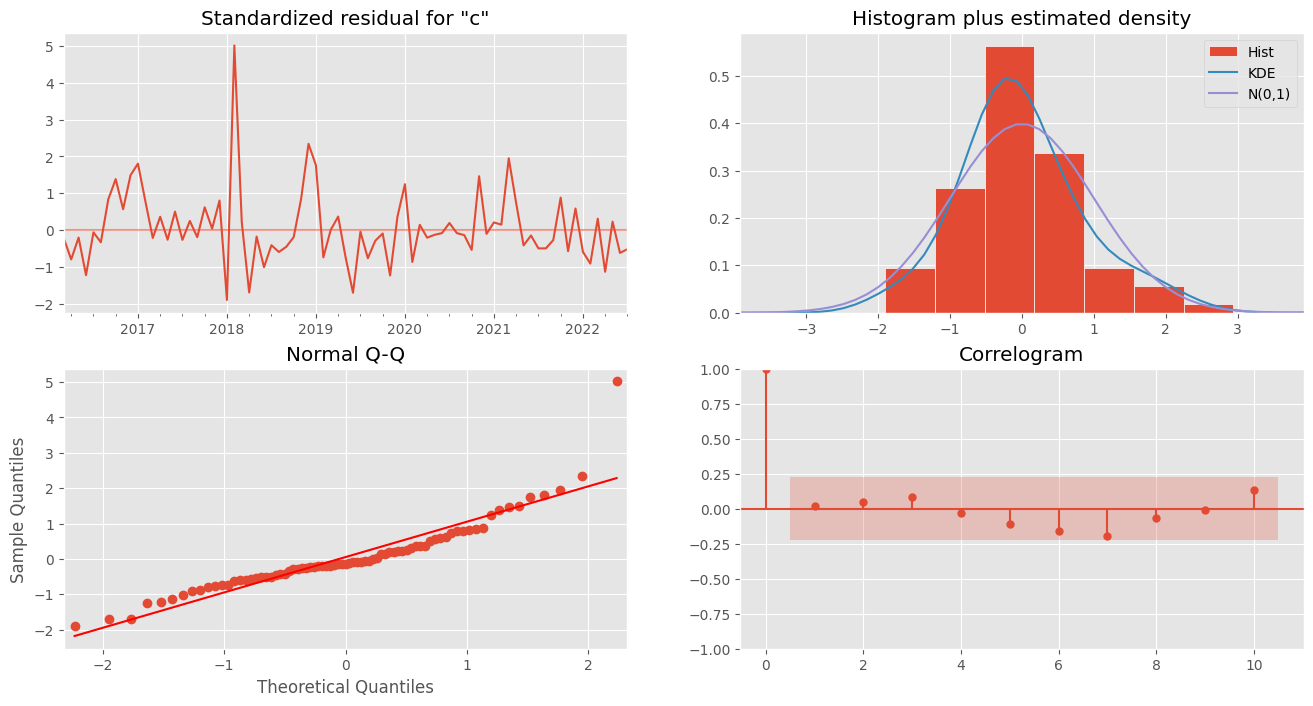

In [81]:
#fitting model
sarima_model_12 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_12 = sarima_model_12.fit()
#grafic
sarima_fit_12.plot_diagnostics(figsize=(16, 8))
plt.show()

#conform graficelor ipotezele pe reziduuri sunt respectate
#reziduurile par a urmari o evolutie homocedastica si o distributie normala
#mai mult,conform corelogramei nu exista autocorelare in serie
#modelul ales este unul valid

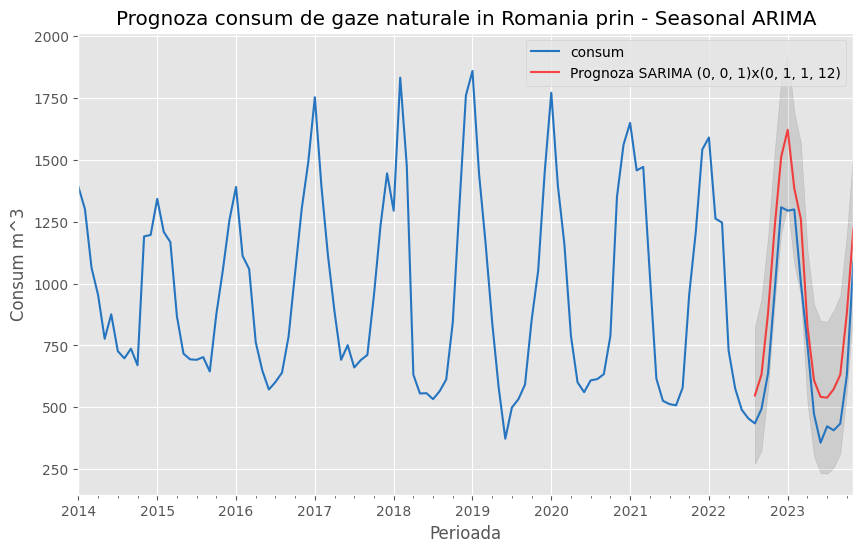

In [75]:
# One step ahead forecast
sarima_predict_12 = sarima_fit_12.get_prediction(start=pd.to_datetime('2022-08-01'), end=pd.to_datetime('2023-11-01')
                                           ,dynamic=False)
sarima_predict_conf_12 = sarima_predict_12.conf_int()
#observed plot
ax = df.plot(label='Initial',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_12.predicted_mean.plot(ax=ax, label='Prognoza SARIMA (0, 0, 1)x(0, 1, 1, 12)', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_12.index,
                #lower sales
                sarima_predict_conf_12.iloc[:, 0],
                #upper sales
                sarima_predict_conf_12.iloc[:, 1], color='k', alpha=0.1)
plt.title('Prognoza consum de gaze naturale in Romania prin - Seasonal ARIMA')
plt.xlabel('Perioada')
plt.ylabel('Consum m^3')
plt.legend()
plt.show()

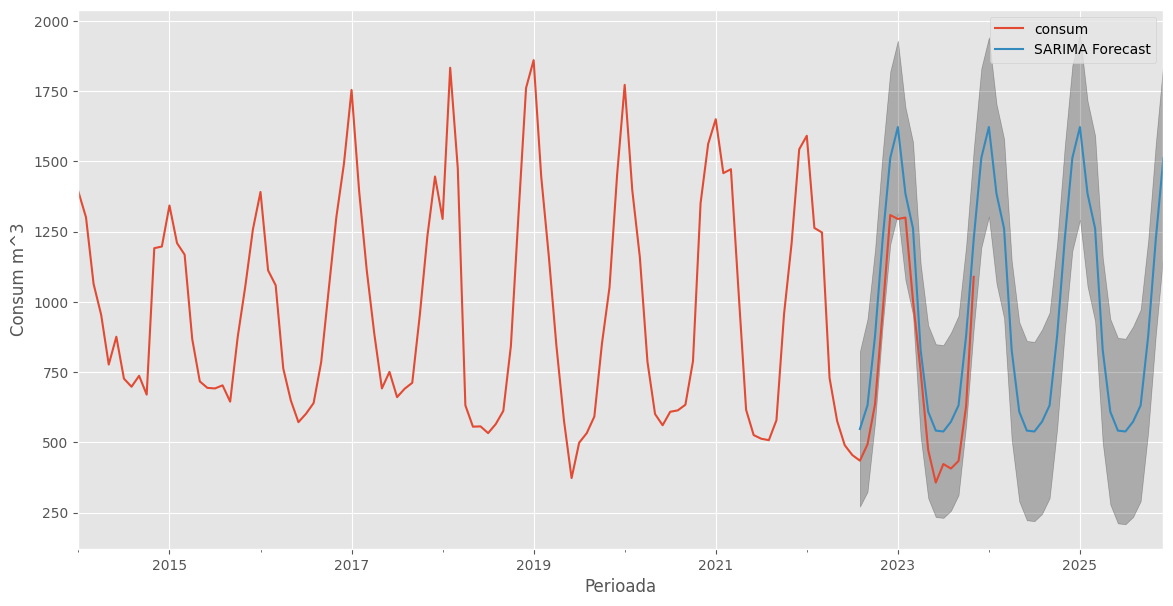

In [76]:
#prognoza perioadele urmatoare
furthur_predict_1 = sarima_fit_12.get_forecast(steps=41)
furthur_conf_1 = furthur_predict_1.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Forecast')
ax.fill_between(furthur_conf_1.index,
                furthur_conf_1.iloc[:, 0],
                furthur_conf_1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Perioada')
ax.set_ylabel('Consum m^3')
plt.legend()
plt.show()

In [77]:
prediction_data = {
        'Consum prognozat prin SARIMA ':furthur_predict_1.predicted_mean}

prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Consum prognozat prin SARIMA
2022-08-01,547.764181
2022-09-01,631.727664
2022-10-01,880.062216
2022-11-01,1223.664116
2022-12-01,1512.045980
2023-01-01,1622.111096
2023-02-01,1385.189863
2023-03-01,1260.964695
2023-04-01,829.123988
2023-05-01,609.280508


In [78]:
#obs ca valorile previzionate includ si perioada din testset 
#astfel vom alege a afisa doar valorile previzionate pentru perioadele pt care nu exista inregistrari 
#din cele 41 de perioade prognozate vom scadea cele 16 valori din trainset 
#vom ramane cu 25 valori prognozate,adica luna dec 2023 si urmatorii 2 ani,2024-2025
prediction=prediction_table.tail(25)
prediction

,Consum prognozat prin SARIMA
2023-12-01,1512.045980
2024-01-01,1622.111096
2024-02-01,1385.189863
2024-03-01,1260.964695
2024-04-01,829.123988
2024-05-01,609.280508
2024-06-01,541.946664
2024-07-01,538.874724
2024-08-01,573.646399
2024-09-01,631.727664
